In [1]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
from glob import glob
import numpy as np
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
sys.path.append("..")
from spatial_transform.aff_mnist_data import IMAGE_SIZE, IMAGE_SHAPE, IMAGE_NUM_CHANNELS, get_aff_mnist_data
from spatial_transform.spatial_transforms import AffineTransform, QuadraticTransform
from spatial_transform.st_blocks import SimpleSpatialTransformBlock
from spatial_transform.localization import StandardConvolutionalLocalizationLayer, CoordConvLocalizationLayer, LargeLocalizationLayer
from spatial_transform.interpolation import BilinearInterpolator
from spatial_transform.layers import RepeatWithSharedWeights, LayerChain
from spatial_transform.visualization import show_train_progress

In [4]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

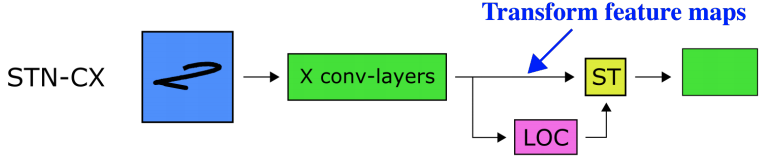

In [5]:
Image("../images/stn_cx.png")

We repete this block 3 times with shared weights

In [6]:
image = tf.keras.layers.Input(shape=IMAGE_SHAPE + (IMAGE_NUM_CHANNELS,))
size_after_transform = 28
num_channels = 16

spatial_transform = AffineTransform()
st_block = SimpleSpatialTransformBlock(
    localization_layer = CoordConvLocalizationLayer(
        spatial_transform_params_cls = spatial_transform.param_type,
        init_scale = 1,
    ),
    spatial_transform = spatial_transform,
    interpolator = BilinearInterpolator(),
    shape_out = (size_after_transform, size_after_transform)
)
stn_cx_block = LayerChain([st_block, tf.keras.layers.Conv2D(num_channels, [5, 5], activation='relu', padding="same")])
stn_cx_chain = RepeatWithSharedWeights(layer=stn_cx_block, num_repetitions=3)

x = tf.image.resize(image, size=(size_after_transform, size_after_transform))
x = tf.keras.layers.Lambda(lambda x: tf.tile(x, [1,1,1,num_channels]))(x)
x = stn_cx_chain(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
tf.image.resize (TFOpLambda) (None, 28, 28, 1)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 16)        0         
_________________________________________________________________
repeat_with_shared_weights ( (None, 28, 28, 16)        25574     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          25632 

In [7]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [8]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 10,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/10
12500/12500 [==============================] - 614s 49ms/step - loss: 1.3877 - accuracy: 0.6010 - val_loss: 0.1416 - val_accuracy: 0.9552
Epoch 2/10
12500/12500 [==============================] - 598s 48ms/step - loss: 0.1433 - accuracy: 0.9559 - val_loss: 0.0931 - val_accuracy: 0.9703
Epoch 3/10
12500/12500 [==============================] - 584s 47ms/step - loss: 0.0986 - accuracy: 0.9695 - val_loss: 0.0760 - val_accuracy: 0.9756
Epoch 4/10
12500/12500 [==============================] - 584s 47ms/step - loss: 0.0791 - accuracy: 0.9754 - val_loss: 0.0698 - val_accuracy: 0.9775
Epoch 5/10
12500/12500 [==============================] - 584s 47ms/step - loss: 0.0667 - accuracy: 0.9791 - val_loss: 0.0813 - val_accuracy: 0.9747
Epoch 6/10
12500/12500 [==============================] - 584s 47ms/step - loss: 0.0703 - accuracy: 0.9783 - val_loss: 0.0559 - val_accuracy: 0.9820
Epoch 7/10
12500/12500 [==============================] - 584s 47ms/step - loss: 0.0540 - accuracy: 0.9830

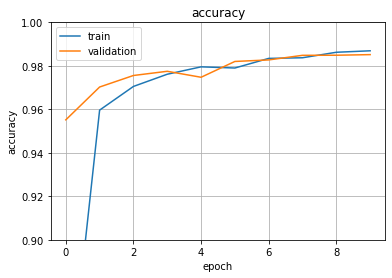

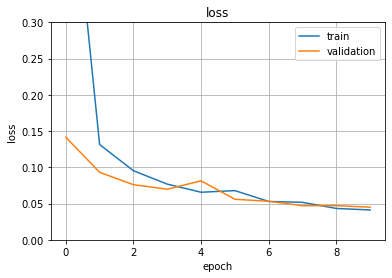

In [9]:
show_train_progress(history)

In [10]:
# model.save_weights("STN_CX_backbone.h5")

### Investigate transformed features

In [11]:
labels = test_img_label[0:20]
images = tf.cast(tf.expand_dims(test_img_data[0:20], 3), dtype=tf.float32)

In [12]:
x = tf.image.resize(images, size=(size_after_transform, size_after_transform))
x = tf.keras.layers.Lambda(lambda x: tf.tile(x, [1,1,1,num_channels]))(x)
transformed_images = stn_cx_chain(x)

0


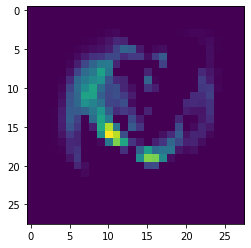

1


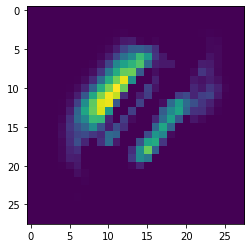

2


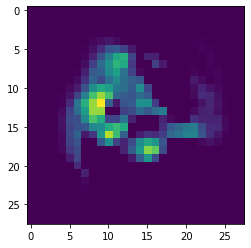

7


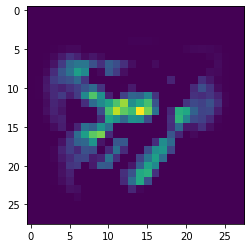

3


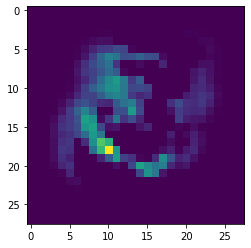

9


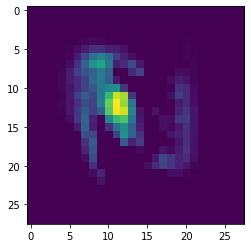

4


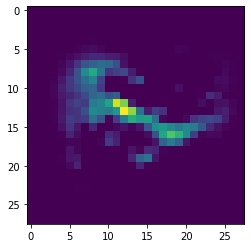

8


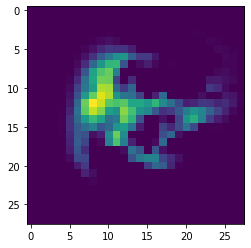

6


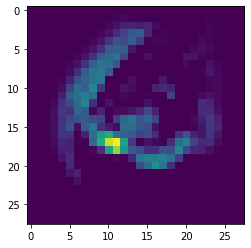

5


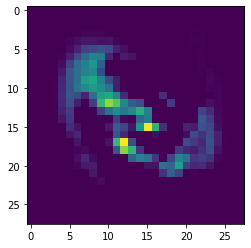

1


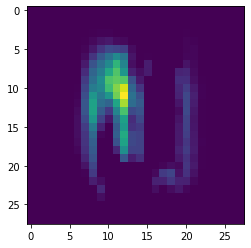

2


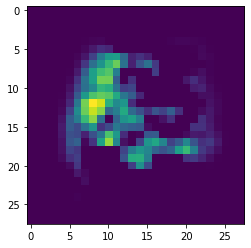

7


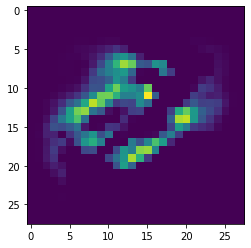

3


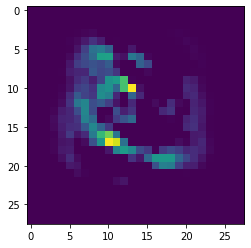

9


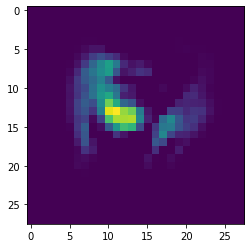

4


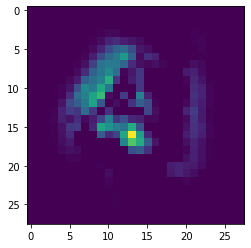

0


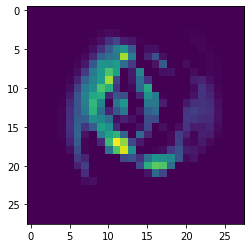

8


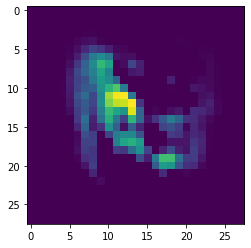

6


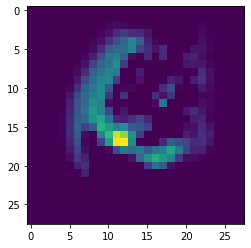

5


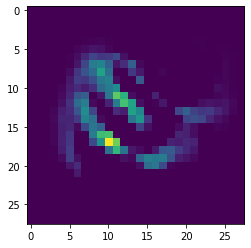

In [13]:
for image, label in zip(transformed_images, labels):
    print(label)
    plt.imshow(image.numpy()[:,:,2])
    plt.show()
